In [1]:
import mne
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys
import os
import pathlib
SCRIPT_DIR = pathlib.Path.cwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))


from continuous_control_bci.data.load_data import load_from_file, adjust_info
from continuous_control_bci.data.preprocessing import apply_causal_filters, make_epochs, epochs_to_train_test
from continuous_control_bci.modelling.csp_classifier import create_csp_classifier

mne.set_log_level('warning') # noqa


raw = load_from_file("../data/pilot_1/calibration/horse_reighns_pilot_driving.gdf")
raw = raw.set_eeg_reference()
raw = adjust_info(raw)
raw = apply_causal_filters(raw)
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


In [2]:
epochs = make_epochs(raw)
epochs

Number of events,80
Events,left: 20rest: 40right: 20
Time range,2.250 – 6.500 s
Baseline,off


In [3]:
from sklearn.model_selection import train_test_split

X = epochs.get_data(copy=True, picks=['eeg'])
y = epochs.get_data(copy=True, picks=['emg'])
annotations = epochs.events[:, -1] - 1
X_train, X_test, y_train, y_test, a_train, a_test = train_test_split(X, y, annotations, test_size=0.1, random_state=42)
print(X_train.shape)
print(y_train.shape)

(72, 32, 8705)
(72, 4, 8705)


In [4]:
import numpy as np
y_train_power = np.abs(y_train).mean(axis=2)
print(y_train_power.shape)
print(y_train_power.mean(axis=0))

(72, 4)
[2.18701092e-05 4.69227923e-05 3.53140500e-05 2.58645393e-05]


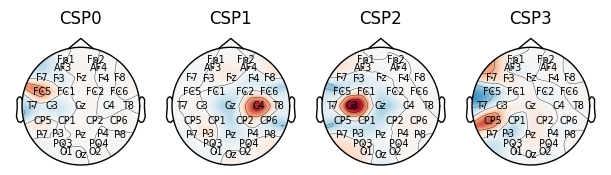

In [5]:
from sklearn.svm import SVR
from mne.decoding import CSP

from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor


# y_pred = cross_val_predict(clf_eeg, X_train, y_train_power, cv=5)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
x_csp = csp.fit_transform(X_train, a_train)

regression = MultiOutputRegressor(SVR())
regression.fit(x_csp, y_train_power)

csp.plot_filters(info=raw.pick('eeg').info, show_names=True, colorbar=False)
plt.show()

In [35]:
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def train_system(x_train_sub, y_train_sub, a_train_sub):
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    emg_normalisation = y_train_sub.max()
    print(emg_normalisation)
    emg_regression = MultiOutputRegressor(SVR())
    label_classification = LDA()
    label_classification.fit(y_train_sub, a_train_sub)

    csp_values = csp.fit_transform(x_train_sub, a_train_sub)

    normalised_true_emg = y_train_sub / emg_normalisation
    emg_regression.fit(csp_values, normalised_true_emg)

    predicted_emg = emg_regression.predict(csp_values) * emg_normalisation
    
    return csp, emg_normalisation, emg_regression, label_classification

def make_predictions(x, csp, emg_normaliser, emg_regression, label_classifier):
    csp_values = csp.transform(x)
    predicted_emg = emg_regression.predict(csp_values) * emg_normaliser

    return label_classifier.predict(predicted_emg)



    
    

    

    


x_train_sub, x_val, y_train_sub, y_val, a_train_sub, a_val = train_test_split(X_train, y_train_power[:, 1:3], a_train, test_size=0.1, random_state=42)


model_pipeline = train_system(x_train_sub, y_train_sub, a_train_sub)
train_predictions = make_predictions(x_train_sub, *model_pipeline)
val_predictions = make_predictions(x_val, *model_pipeline)

0.00021141248895218195


              precision    recall  f1-score   support

        Left       0.91      0.71      0.80        14
       Right       0.88      0.93      0.90        15
        Rest       0.89      0.94      0.92        35

    accuracy                           0.89        64
   macro avg       0.89      0.86      0.87        64
weighted avg       0.89      0.89      0.89        64



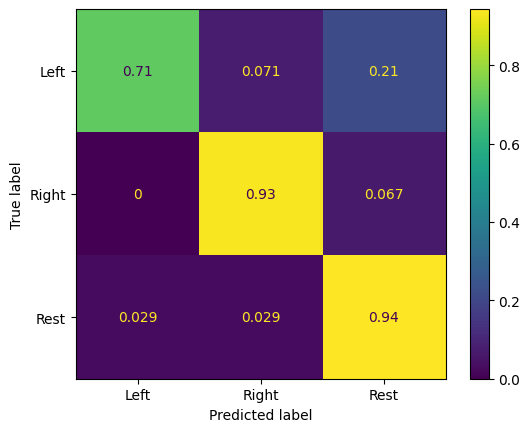

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
print(classification_report(a_train_sub, train_predictions, target_names=['Left', 'Right', 'Rest']))

ConfusionMatrixDisplay.from_predictions(a_train_sub, train_predictions,  display_labels=["Left", "Right", "Rest"], normalize='true')
plt.show()

              precision    recall  f1-score   support

        Left       0.00      0.00      0.00         3
       Right       0.50      1.00      0.67         1
        Rest       0.50      0.75      0.60         4

    accuracy                           0.50         8
   macro avg       0.33      0.58      0.42         8
weighted avg       0.31      0.50      0.38         8



/Users/ivopascal/.local/share/virtualenvs/continuous_control_bci-_i6LbcKu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ivopascal/.local/share/virtualenvs/continuous_control_bci-_i6LbcKu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ivopascal/.local/share/virtualenvs/continuous_control_bci-_i6LbcKu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

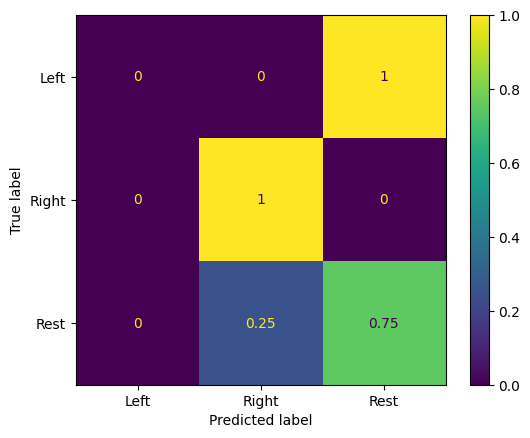

In [38]:
print(classification_report(a_val, val_predictions, target_names=['Left', 'Right', 'Rest']))

ConfusionMatrixDisplay.from_predictions(a_val, val_predictions,  display_labels=["Left", "Right", "Rest"], normalize='true')
plt.show()

In [42]:
val_preds = []
val_trues = []

for i in range(10):
    x_train_sub, x_val, y_train_sub, y_val, a_train_sub, a_val = train_test_split(X_train, y_train_power[:, 1:], a_train, test_size=0.1, random_state=i)
    
    
    model_pipeline = train_system(x_train_sub, y_train_sub, a_train_sub)
    train_predictions = make_predictions(x_train_sub, *model_pipeline)
    val_predictions = make_predictions(x_val, *model_pipeline)
    val_preds.append(val_predictions)
    val_trues.append(a_val)

val_preds = np.concatenate(val_preds)
val_trues = np.concatenate(val_trues)


0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.00021141248895218195
0.0002020558136328952


              precision    recall  f1-score   support

        Left       0.70      0.44      0.54        16
       Right       0.85      0.52      0.65        21
        Rest       0.72      0.95      0.82        43

    accuracy                           0.74        80
   macro avg       0.76      0.64      0.67        80
weighted avg       0.75      0.74      0.72        80



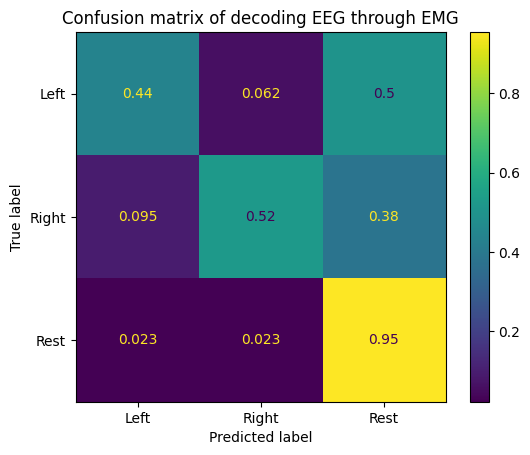

In [51]:
# This does not not very promising at first glance, but it's actually not _that_ bad.
# We see left and right _rare_ get confused.
# We also see minimal false positives
# We do haowever see a recall rate of only about 50%.
# This means that every other "movement" would be classified (correctly!). The other movements would be skipped.



print(classification_report(val_trues, val_preds, target_names=['Left', 'Right', 'Rest']))

ConfusionMatrixDisplay.from_predictions(val_trues, val_preds,  display_labels=["Left", "Right", "Rest"], normalize='true')
plt.title("Confusion matrix of decoding EEG through EMG")
plt.show()

In [52]:
values, counts = np.unique(val_trues, return_counts=True)
print(values)
counts / counts.sum()

[0 1 2]


array([0.2   , 0.2625, 0.5375])

In [10]:
mses = np.array(mses)

NameError: name 'mses' is not defined

In [ ]:
# [0.01468139 0.00831924]
# [0.0079167  0.00294372]
print(np.mean(mses, axis=0) * 1e6) # To turn it into microvolts off. 
print(np.std(mses, axis=0) * 1e6)

In [ ]:
y_train_power.shape

In [ ]:
random_guess_mses = ((y_train_power.mean(axis=0).reshape(1, 2).repeat(y_train_power.shape[0], axis=0) - y_train_power) ** 2).mean(axis=0) * 1e6
random_guess_mses

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
# So this does show that performance is better than random guessing.
# Not much I should say, but it is better. 


df = pd.DataFrame([
    [0.00323304, 0.00323304, 0.00323304],
    [0.00183517, 0.00183517 + 0.00098959, 0.00183517 - 0.00098959],
    [0.00147237, 0.00147237, 0.00147237],
    [0.00103991, 0.00103991 + 0.00036797, 0.00103991 - 0.00036797],
]).T
sns.barplot(df)
plt.show()

In [ ]:
sns.barplot([0.00183517, 0.00103991, 0.00323304, 0.00147237])
plt.show()

In [ ]:
plt.boxplot(mses)
# plt.boxplot((y_train_power.mean(axis=0).reshape(1, 2).repeat(y_train_power.shape[0], axis=0) - y_train_power) ** 2)
plt.show()

In [ ]:
mse = (y_train.mean * maximum_emg - y_val) ** 2).sum()

In [ ]:
csp.plot_filters(info=raw.pick('eeg').info, show_names=True, colorbar=False)
plt.show()

In [ ]:
a_train_sub

In [ ]:
# This nicely shows that the classes are definetly nicely separable by CSP

plt.scatter(x_sub_csp[:, 2], x_sub_csp[:, 3], c=a_train_sub)
plt.title("Different classes under different CSP filters")
plt.xlabel("CSP 2")
plt.ylabel("CSP 3")
plt.show()

In [ ]:
# This nicely shows that the classes are definetly nicely separable by CSP

plt.scatter(x_sub_csp[:, 2], x_sub_csp[:, 3], c=y_train_sub[:, 0])
plt.title("EMG power on Left Arm under different CSP filters")
plt.xlabel("CSP 2")
plt.ylabel("CSP 3")
plt.show()

In [ ]:
plt.scatter(x_sub_csp[:, 2], x_sub_csp[:, 3], c=y_train_sub[:, 1])
plt.title("EMG power on Right Arm under different CSP filters")
plt.xlabel("CSP 2")
plt.ylabel("CSP 3")
plt.show()

In [ ]:
# This plot is a bit heavy but I promise it makes sense.
# This is given CSP 2 we find the EMG.
# Dots are "congruent" e.g. right arm on right trial
# x is "incongruous" e.g. left arm on right trial
# + are rest trials
# Red is left arm
# Blue is right arm

# We can see from this:
# Each arm has substantially more power on congruent trials
# Rest trials seem to correspond with positive values
# Both right and left hand seem to have _some_ activation on negative values.

plt.scatter(x_sub_csp[:, 2][a_train_sub == 0], y_train_sub[:, 0][a_train_sub == 0], label="Left arm Left trial", marker='o', c='r')
plt.scatter(x_sub_csp[:, 2][a_train_sub == 1], y_train_sub[:, 0][a_train_sub == 1], label="Left arm Right trial", marker='x', c='r')
plt.scatter(x_sub_csp[:, 2][a_train_sub == 2], y_train_sub[:, 0][a_train_sub == 2], label="Left arm Rest trial", marker='+', c='r')


plt.title("Arm powers for CSP 2")


plt.scatter(x_sub_csp[:, 2][a_train_sub == 0], y_train_sub[:, 1][a_train_sub == 0], label="Right arm Left trial", marker='x', c='b')
plt.scatter(x_sub_csp[:, 2][a_train_sub == 1], y_train_sub[:, 1][a_train_sub == 1], label="Right arm Right trial", marker='o', c='b')
plt.scatter(x_sub_csp[:, 2][a_train_sub == 2], y_train_sub[:, 1][a_train_sub == 2], label="Right arm Rest trial", marker='+', c='b')


# These plot the predictions in relation to the actual emg, but this is difficult to interpret
# plt.scatter(csp.transform(x_val)[:, 2], y_pred[:, 0]*maximum_emg, c='g')
# plt.scatter(csp.transform(x_val)[:, 2], y_val[:, 0], c='g', marker='+')

# plt.scatter(csp.transform(x_val)[:, 2], y_pred[:, 1]*maximum_emg, c='black')
# plt.scatter(csp.transform(x_val)[:, 2], y_val[:, 1], c='black', marker='+')

plt.title("Arm power for CSP 2")
plt.xlabel("CSP 2")
plt.ylabel("EMG power")
plt.legend()
plt.show()


In [ ]:
# If we ignore the "rest" trials we might begin to see more of a pattern
# In blue we see a positive correlation with EMG power and CSP. Specifically, when CSP is low (<-0.6) EMG is also low.
# When CSP is high (>-0.5) EMG is also high (0.0001). So, we can see a positive correlation.

# Meanwhile for red (left hand) we see a negative correlation.
# When CSP <-0.5 EMG is high, when it's more EMG is low. 

# So this CSP is positively correlated with right hand, and negative correlated with left hand.
# CSP2 has selection for the right hemisphere. This is inverse to what we'd expect (we'd expect contralateral activation)
# Is there something with flipped polarity, going on?


plt.scatter(x_sub_csp[:, 2][a_train_sub == 0], y_train_sub[:, 0][a_train_sub == 0], label="Left arm Left trial", marker='o', c='r')
plt.scatter(x_sub_csp[:, 2][a_train_sub == 1], y_train_sub[:, 0][a_train_sub == 1], label="Left arm Right trial", marker='x', c='r')
# plt.scatter(x_sub_csp[:, 2][a_train_sub == 2], y_train_sub[:, 0][a_train_sub == 2], label="Left arm Rest trial", marker='+', c='r')


plt.title("Arm powers for CSP 2")


plt.scatter(x_sub_csp[:, 2][a_train_sub == 0], y_train_sub[:, 1][a_train_sub == 0], label="Right arm Left trial", marker='x', c='b')
plt.scatter(x_sub_csp[:, 2][a_train_sub == 1], y_train_sub[:, 1][a_train_sub == 1], label="Right arm Right trial", marker='o', c='b')
# plt.scatter(x_sub_csp[:, 2][a_train_sub == 2], y_train_sub[:, 1][a_train_sub == 2], label="Right arm Rest trial", marker='+', c='b')
plt.title("Arm power for CSP 2")
plt.xlabel("CSP 2")
plt.ylabel("EMG power")
plt.legend()
plt.show()

In [ ]:
# On CSP 3 I can already see that any effect we're looking for is weaker.
# There is EMG power regardless of the activation. 

plt.scatter(x_sub_csp[:, 3][a_train_sub == 0], y_train_sub[:, 0][a_train_sub == 0], label="Left arm Left trial", marker='o', c='r')
plt.scatter(x_sub_csp[:, 3][a_train_sub == 1], y_train_sub[:, 0][a_train_sub == 1], label="Left arm Right trial", marker='x', c='r')
# plt.scatter(x_sub_csp[:, 2][a_train_sub == 2], y_train_sub[:, 0][a_train_sub == 2], label="Left arm Rest trial", marker='+', c='r')




plt.scatter(x_sub_csp[:, 3][a_train_sub == 0], y_train_sub[:, 1][a_train_sub == 0], label="Right arm Left trial", marker='x', c='b')
plt.scatter(x_sub_csp[:, 3][a_train_sub == 1], y_train_sub[:, 1][a_train_sub == 1], label="Right arm Right trial", marker='o', c='b')
# plt.scatter(x_sub_csp[:, 2][a_train_sub == 2], y_train_sub[:, 1][a_train_sub == 2], label="Right arm Rest trial", marker='+', c='b')
plt.title("Arm power for CSP 3")
plt.xlabel("CSP 3")
plt.ylabel("EMG power")
plt.legend()
plt.show()

In [ ]:
plt.scatter(x_sub_csp[:, 2], y_train_sub[:, 0])
plt.title("Right arm power for CSP 3")
plt.xlabel("CSP 3")
plt.ylabel("EMG power Left")
plt.show()

In [72]:
from sklearn.linear_model import LogisticRegression

val_preds = []
val_trues = []

for i in range(10):  
    eeg_train_sub, eeg_val_sub, emg_train_sub, emg_val_sub, truth_train_sub, truth_val_sub = train_test_split(X_train, y_train_power[:, 1:3], a_train, test_size=0.1, random_state=i)
    
    emg_to_truth = LDA()
    emg_to_truth.fit(emg_train_sub, truth_train_sub)
    quasi_truth_train_sub = emg_to_truth.predict(emg_train_sub)
    
    
    eeg_to_truth = Pipeline([("CSP", CSP(n_components=4, reg=None, log=True, norm_trace=False)),
                ("classifier", LogisticRegression())])
    eeg_to_truth.fit(eeg_train_sub, quasi_truth_train_sub)
    train_pred = eeg_to_truth.predict(eeg_train_sub)

    val_predictions = eeg_to_truth.predict(eeg_val_sub)


    val_preds.append(val_predictions)
    val_trues.append(truth_val_sub)

val_preds = np.concatenate(val_preds)
val_trues = np.concatenate(val_trues)


              precision    recall  f1-score   support

        Left       0.55      0.75      0.63        16
       Right       0.73      0.52      0.61        21
        Rest       0.95      0.95      0.95        43

    accuracy                           0.80        80
   macro avg       0.74      0.74      0.73        80
weighted avg       0.81      0.80      0.80        80



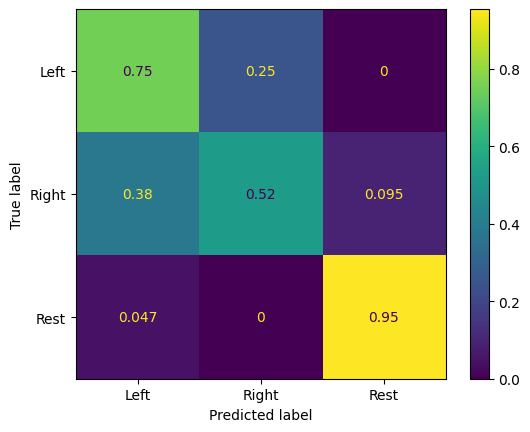

In [73]:
print(classification_report(val_trues, val_preds, target_names=["Left", "Right", "Rest"]))
ConfusionMatrixDisplay.from_predictions(val_trues, val_preds, display_labels=["Left", "Right", "Rest"],
                                        normalize='true')
plt.show()